# Name of the Author -Sayali Redasani

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Stock Market Prediction using Numerical and Textual Analysis
- Create a hybrid model for stock price or performance prediction using numerical analysis of historical stock prices, and sentimental analysis of news headlines. The stock to analyze and predict is SENSEX (S&P BSE SENSEX)

# Import the Important Libraries

In [2]:
# Import the libraries
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

import warnings
warnings.filterwarnings('ignore')


from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import nltk
import re
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost
import lightgbm

In [3]:
# For reading stock data from yahoo
from pandas_datareader.data import DataReader
# For time stamps
from datetime import datetime

In [5]:
# Load the first dataset
columns=['Date','Category','News']
ndf = pd.read_csv("/content/drive/MyDrive/Task 7/india-news-headlines.csv",names=columns)

In [6]:
print('Showing part of the whole dataset:')
ndf.head(5)

Showing part of the whole dataset:


,Date,Category,News
0,publish_date,headline_category,headline_text
1,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
2,20010102,unknown,Fissures in Hurriyat over Pak visit
3,20010102,unknown,America's unwanted heading for India?
4,20010102,unknown,For bigwigs; it is destination Goa


In [7]:
ndf.drop(0, inplace=True)
ndf.drop('Category', axis = 1, inplace=True)
print('Showing part of the whole dataset:')
ndf.head(-5)

Showing part of the whole dataset:


,Date,News
1,20010102,Status quo will not be disturbed at Ayodhya; s...
2,20010102,Fissures in Hurriyat over Pak visit
3,20010102,America's unwanted heading for India?
4,20010102,For bigwigs; it is destination Goa
5,20010102,Extra buses to clear tourist traffic
...,...,...
3650961,20220331,Garment industry jittery over'GST hike'
3650962,20220331,AAP MLAs interfering in work: Councillors
3650963,20220331,Schools organise vax camps for kids
3650964,20220331,Madhya Pradesh CM Shivraj Singh Chouhan promis...


In [8]:
# Load the second dataset
hisdf = pd.read_csv("/content/drive/MyDrive/Task 7/^BSESN.csv")
hisdf.head(-5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-12-17,41052.359375,41401.648438,41005.179688,41352.171875,41352.171875,19000.0
1,2019-12-18,41442.750000,41614.769531,41358.468750,41558.570313,41558.570313,24300.0
2,2019-12-19,41571.820313,41719.289063,41456.398438,41673.921875,41673.921875,33300.0
3,2019-12-20,41746.199219,41809.960938,41636.109375,41681.539063,41681.539063,33600.0
4,2019-12-23,41548.261719,41701.621094,41474.609375,41642.660156,41642.660156,6200.0
...,...,...,...,...,...,...,...
242,2020-12-04,44665.910156,45148.281250,44665.910156,45079.550781,45079.550781,27600.0
243,2020-12-07,45099.921875,45458.921875,45024.468750,45426.968750,45426.968750,18700.0
244,2020-12-08,45568.800781,45742.230469,45335.171875,45608.511719,45608.511719,18200.0
245,2020-12-09,45891.039063,46164.101563,45792.011719,46103.500000,46103.500000,20700.0


# Common Dataset Exploration

In [9]:
# Check for common information of the first datast
ndf["Date"] = pd.to_datetime(ndf["Date"],format='%Y%m%d')
ndf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650970 entries, 1 to 3650970
Data columns (total 2 columns):
 #   Column  Dtype         
---  ------  -----         
 0   Date    datetime64[ns]
 1   News    object        
dtypes: datetime64[ns](1), object(1)
memory usage: 55.7+ MB


In [10]:
# Group the headlines for each day
ndf['News'] = ndf.groupby(['Date']).transform(lambda x : ' '.join(x))
ndf = ndf.drop_duplicates()
ndf.reset_index(inplace=True,drop=True)

In [11]:
ndf

,Date,News
0,2001-01-02,Status quo will not be disturbed at Ayodhya; s...
1,2001-01-03,Powerless north India gropes in the dark Think...
2,2001-01-04,The string that pulled Stephen Hawking to Indi...
3,2001-01-05,Light combat craft takes India into club class...
4,2001-01-06,Light combat craft takes India into club class...
...,...,...
7712,2022-03-27,Playing a dead man in Body God meant sitting i...
7713,2022-03-28,As fashion becomes democratic; demand for styl...
7714,2022-03-29,Bobby Deol: Like my dad; I hope to be working ...
7715,2022-03-30,I will not give in to trends: Dossmode The tim...


In [12]:
# Check for any duplicated values
ndf.isnull().sum()

Date    0
News    0
dtype: int64

In [13]:
len(ndf)

7717

In [14]:
hisdf=hisdf[["Date","Open","High","Low","Close","Volume"]]
hisdf.head(-5)

,Date,Open,High,Low,Close,Volume
0,2019-12-17,41052.359375,41401.648438,41005.179688,41352.171875,19000.0
1,2019-12-18,41442.750000,41614.769531,41358.468750,41558.570313,24300.0
2,2019-12-19,41571.820313,41719.289063,41456.398438,41673.921875,33300.0
3,2019-12-20,41746.199219,41809.960938,41636.109375,41681.539063,33600.0
4,2019-12-23,41548.261719,41701.621094,41474.609375,41642.660156,6200.0
...,...,...,...,...,...,...
242,2020-12-04,44665.910156,45148.281250,44665.910156,45079.550781,27600.0
243,2020-12-07,45099.921875,45458.921875,45024.468750,45426.968750,18700.0
244,2020-12-08,45568.800781,45742.230469,45335.171875,45608.511719,18200.0
245,2020-12-09,45891.039063,46164.101563,45792.011719,46103.500000,20700.0


In [15]:
# Check for common information of the second dataset
hisdf["Date"]= pd.to_datetime(hisdf["Date"])
hisdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    252 non-null    datetime64[ns]
 1   Open    250 non-null    float64       
 2   High    250 non-null    float64       
 3   Low     250 non-null    float64       
 4   Close   250 non-null    float64       
 5   Volume  250 non-null    float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 11.9 KB


In [16]:
hisdf.describe()

,Open,High,Low,Close,Volume
count,250.000000,250.000000,250.000000,250.000000,250.000000
mean,37804.237375,38071.182859,37422.826992,37745.454117,19134.000000
std,4507.985769,4380.974060,4647.212947,4535.304336,16540.261333
min,26499.810547,27462.869141,25638.900391,25981.240234,0.000000
25%,34369.659179,34779.932618,33975.389648,34257.097656,13125.000000
50%,38489.480469,38750.359375,38234.869140,38425.974610,17000.000000
75%,41179.222656,41376.482422,41023.923828,41135.233399,21075.000000
max,46774.320313,46992.570313,46627.601563,46890.339844,188300.000000


In [17]:
# Check for duplicated values
hisdf.isnull().sum()

Date      0
Open      2
High      2
Low       2
Close     2
Volume    2
dtype: int64

In [18]:
len(hisdf)

252

Text(0, 0.5, 'BSESN')

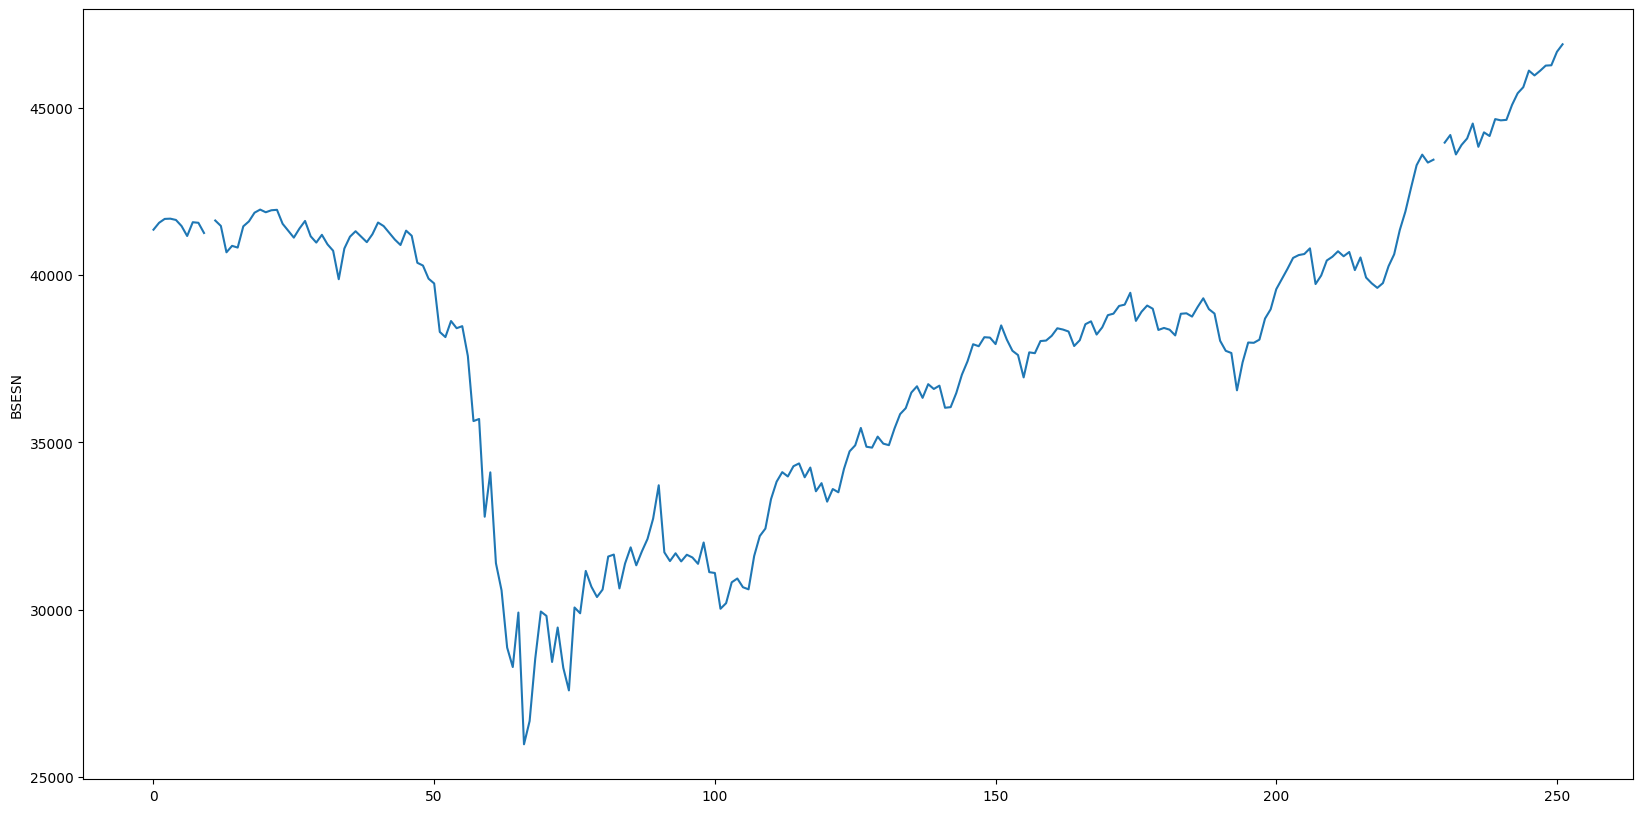

In [19]:
# Figure plot
plt.figure(figsize=(20,10))
hisdf['Close'].plot()
plt.ylabel('BSESN')

# Remove Unwanted Characters from the News

In [20]:
#removing unwanted characters from the News
ndf.replace("[^a-zA-Z']"," ",regex=True,inplace=True)
ndf["News"].head(5)

0    Status quo will not be disturbed at Ayodhya  s...
1    Powerless north India gropes in the dark Think...
2    The string that pulled Stephen Hawking to Indi...
3    Light combat craft takes India into club class...
4    Light combat craft takes India into club class...
Name: News, dtype: object

# Historical Analysis

# Plot the Moving Average

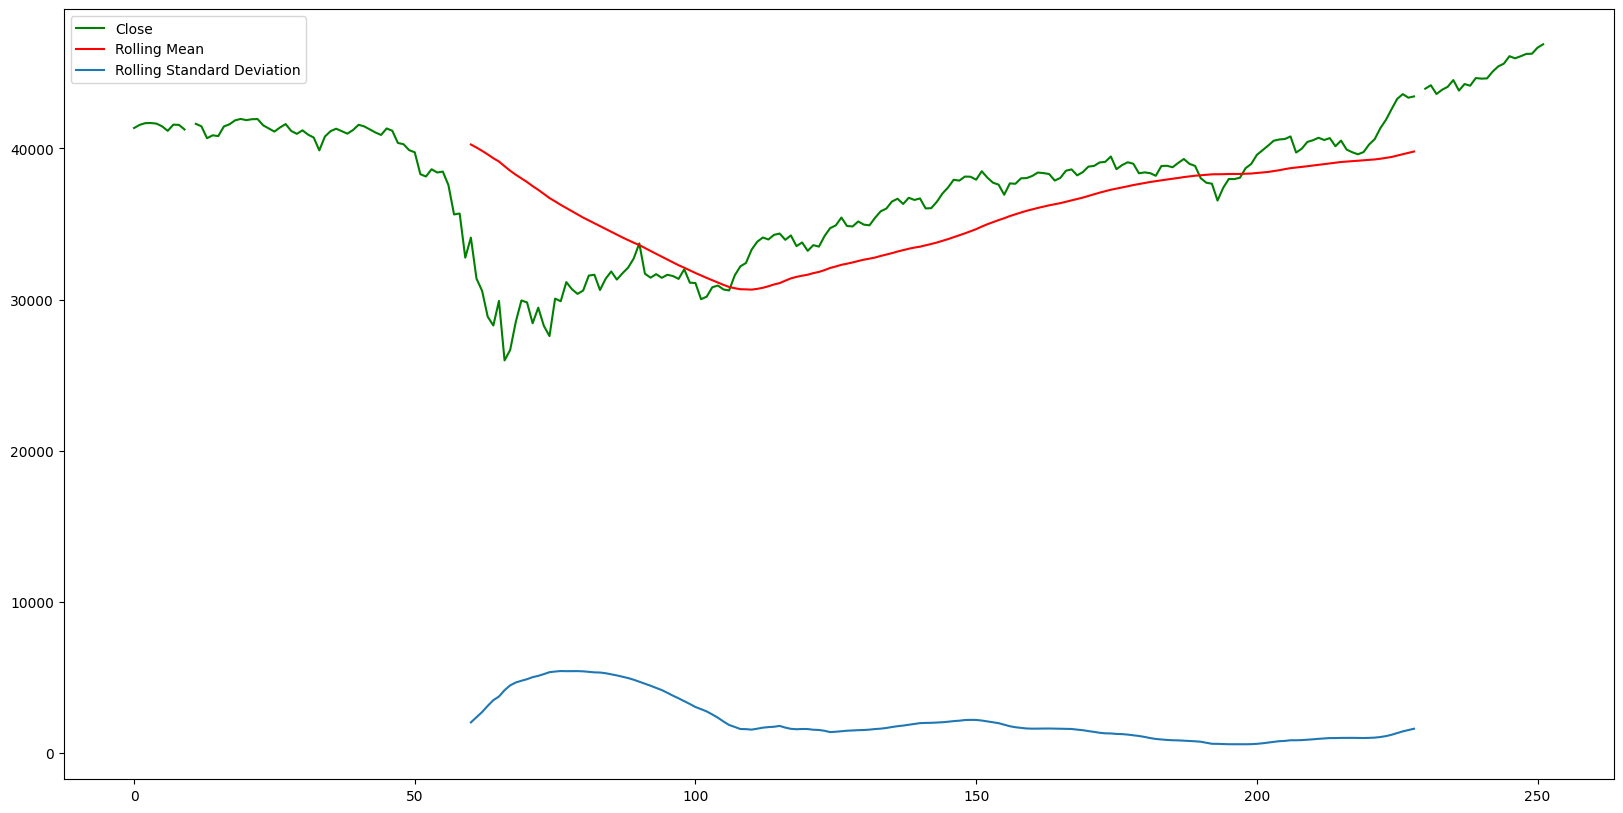

In [21]:
#Plotting moving average
close = hisdf['Close']

ma = close.rolling(window = 50).mean()
std = close.rolling(window = 50).std()

plt.figure(figsize=(20,10))
hisdf['Close'].plot(color='g',label='Close')
ma.plot(color = 'r',label='Rolling Mean')
std.plot(label = 'Rolling Standard Deviation')

plt.legend()

# Plot the Returns

Text(0.5, 1.0, 'Returns')

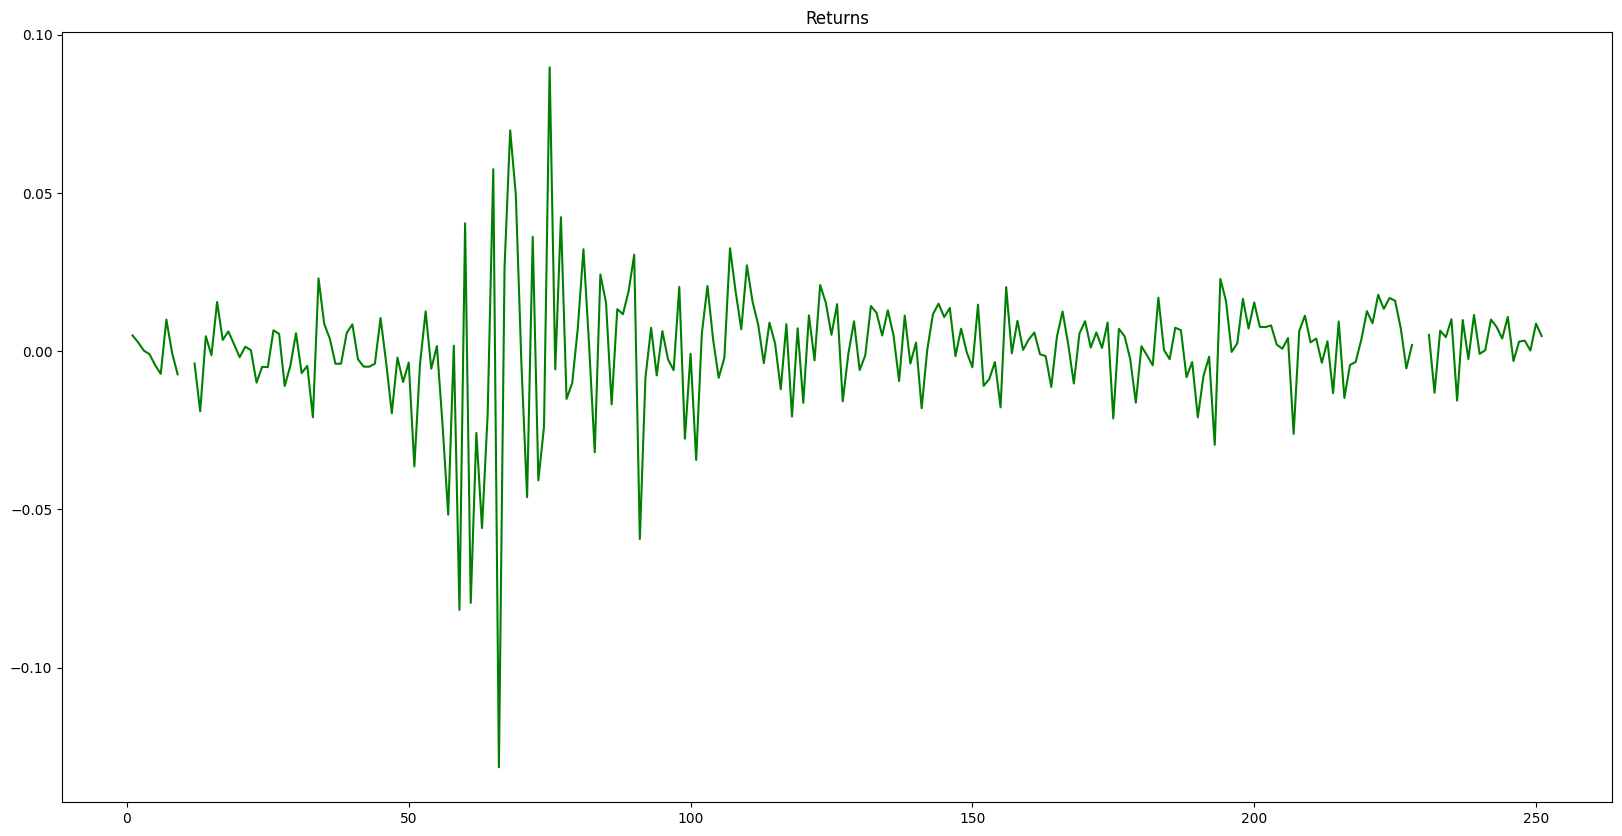

In [22]:
#Plotting returns
returns = close / close.shift(1) - 1

plt.figure(figsize = (20,10))
returns.plot(label='Return', color = 'g')
plt.title("Returns")

In [23]:
# Train test split
train = hisdf[:1219]
test = hisdf[1219:]

# Rolling mean and Standard Deviation

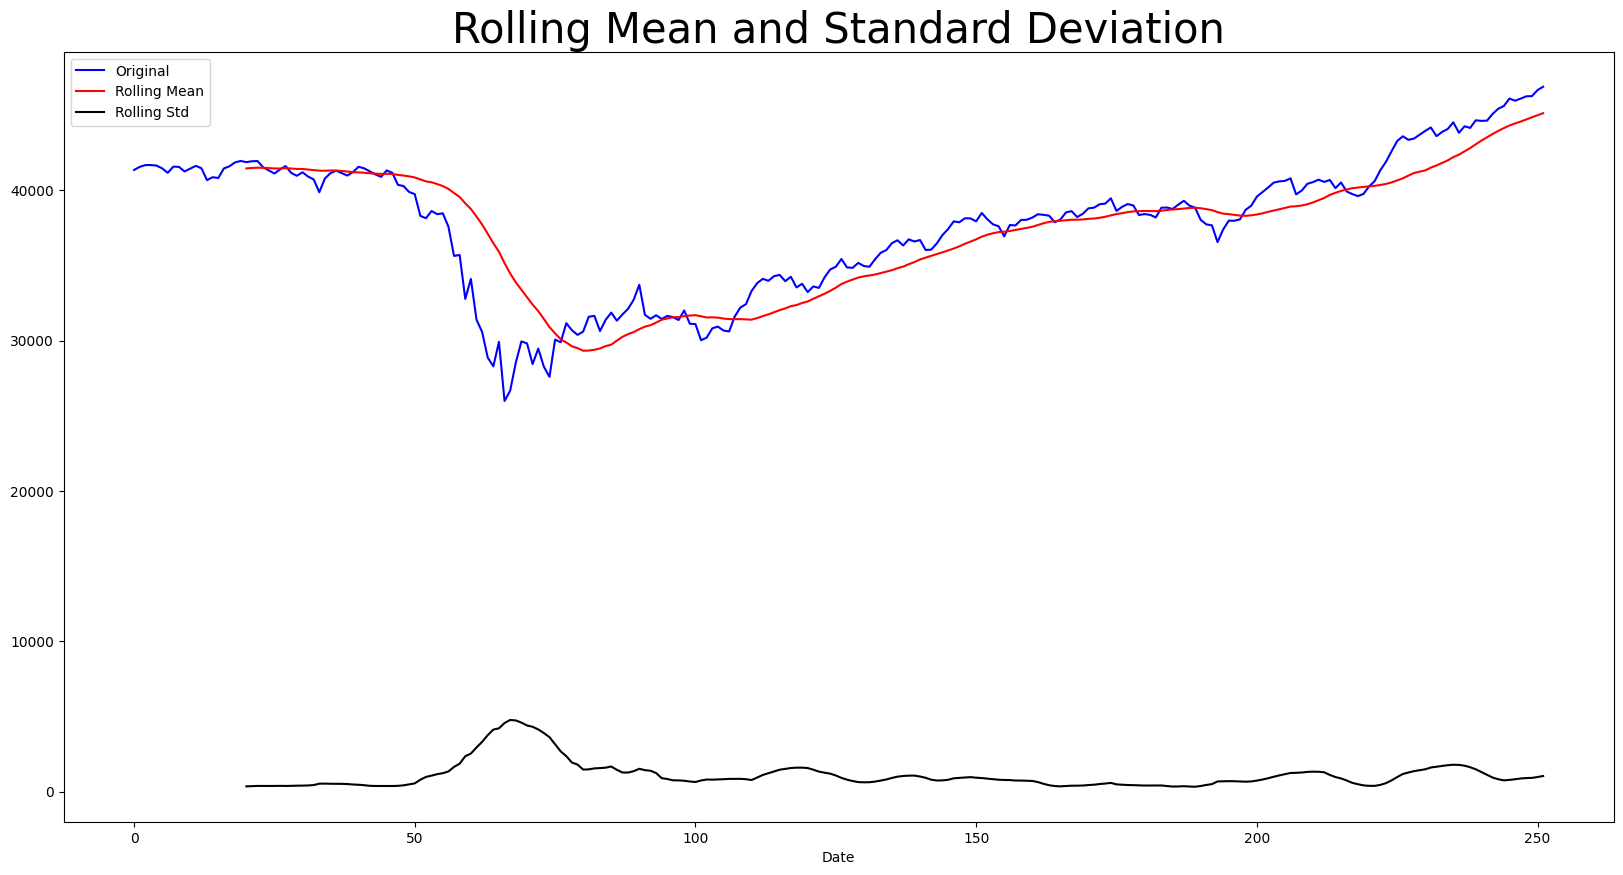

Results of Dickey-Fuller Test
ADF Test Statistic : -0.6982850827498315
p-value : 0.84719324017088
# Lags Used : 6
Number of Observations Used : 243
Weak evidence against the null hypothesis, time series is non-stationary.


In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

# Assuming you have your 'train' DataFrame loaded correctly

def test_stationarity(timeseries):
    # Handle NaN and infinite values
    timeseries = timeseries.dropna()  # Remove rows with NaN values
    timeseries = timeseries.replace([np.inf, -np.inf], np.nan).dropna()  # Replace inf values with NaN and remove them

    # Determine the rolling statistics
    rolmean = timeseries.rolling(20).mean()
    rolstd = timeseries.rolling(20).std()

    # Plot rolling statistics
    plt.figure(figsize=(20, 10))
    plt.plot(timeseries, color='blue', label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label='Rolling Std')
    plt.xlabel('Date')
    plt.legend()
    plt.title('Rolling Mean and Standard Deviation', fontsize=30)
    plt.show(block=False)

    print('Results of Dickey-Fuller Test')
    result = adfuller(timeseries, autolag='AIC')
    labels = ['ADF Test Statistic', 'p-value', '# Lags Used', 'Number of Observations Used']
    for value, label in zip(result, labels):
        print(label + ' : ' + str(value))

    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis (Ho), reject the null hypothesis. Data is stationary.")
    else:
        print("Weak evidence against the null hypothesis, time series is non-stationary.")

# Call the function with your time series data
test_stationarity(train['Close'])


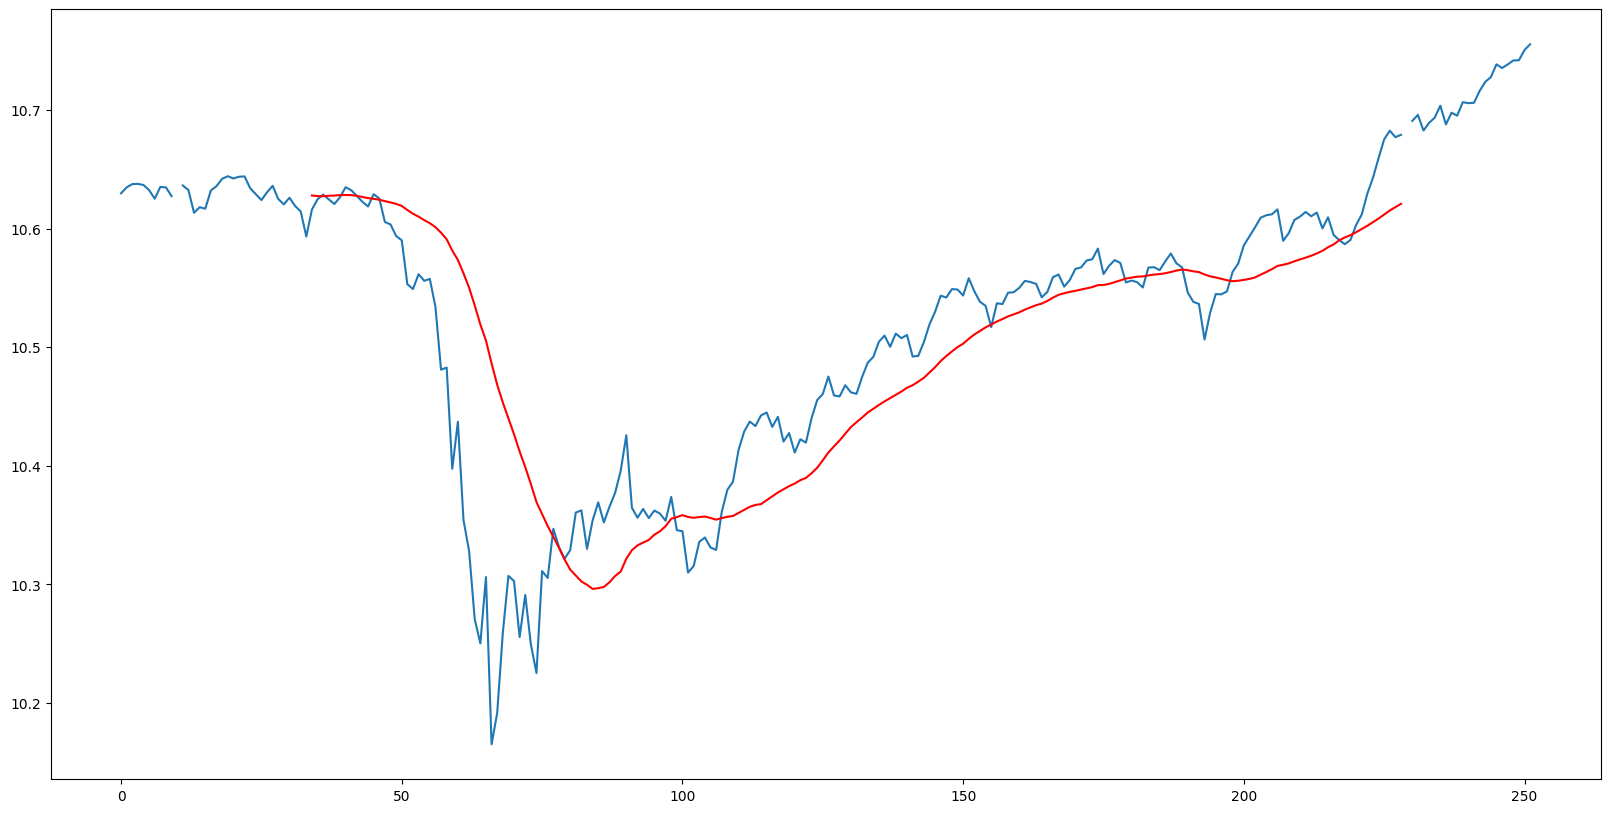

In [25]:
train_log = np.log(train['Close'])
test_log = np.log(test['Close'])

mav = train_log.rolling(24).mean()

plt.figure(figsize = (20,10))
plt.plot(train_log)
plt.plot(mav, color = 'red')

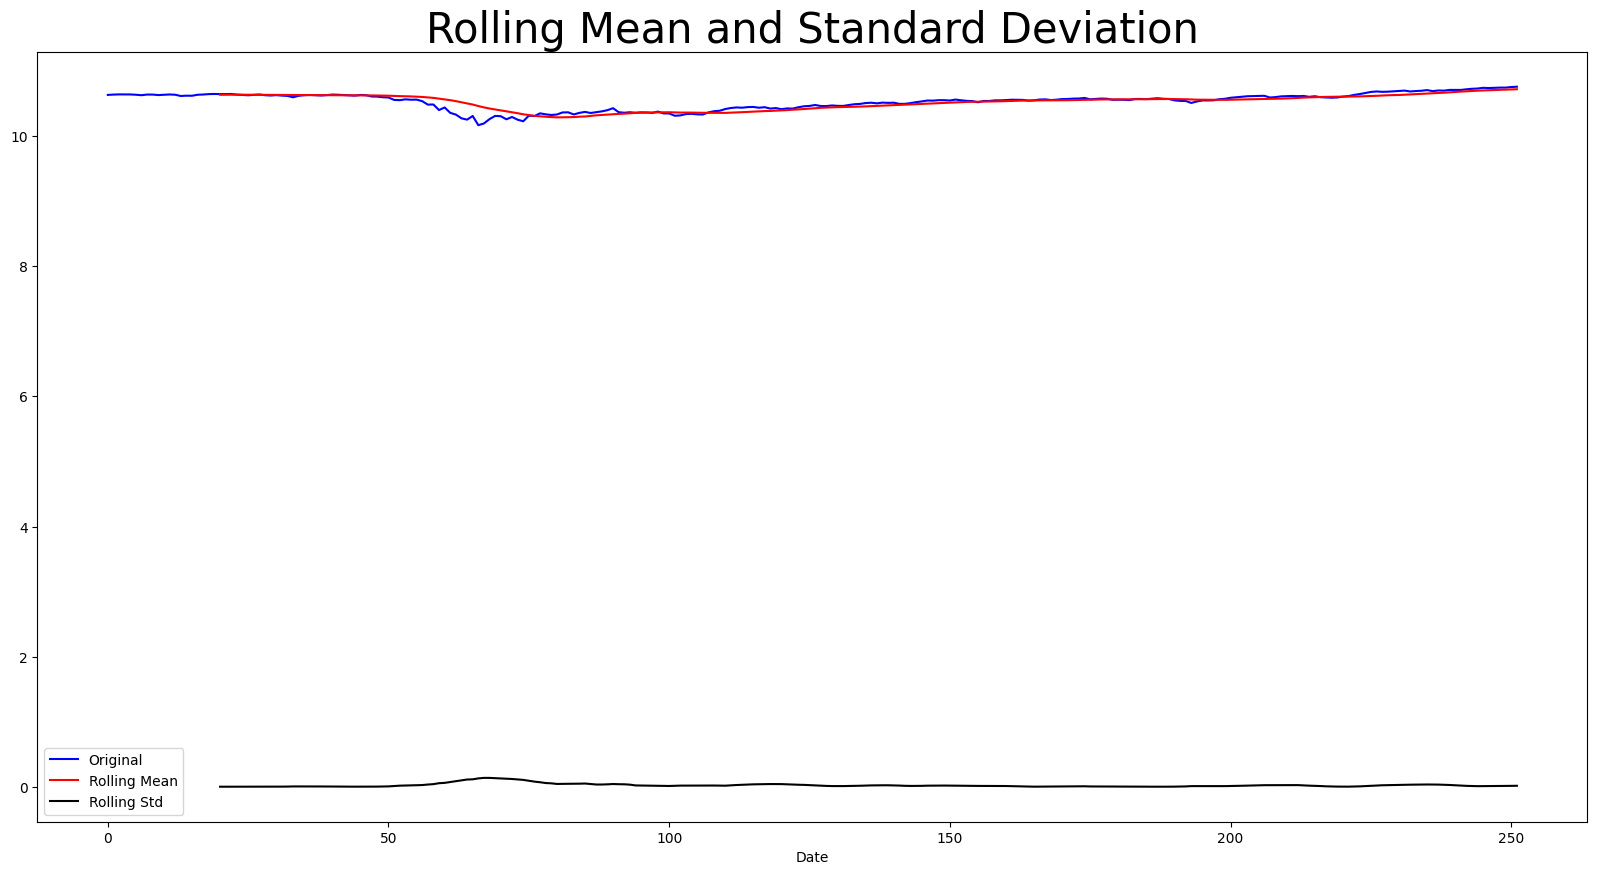

Results of Dickey-Fuller Test
ADF Test Statistic : -1.185702149048305
p-value : 0.6797158478016397
# Lags Used : 7
Number of Observations Used : 242
Weak evidence against the null hypothesis, time series is non-stationary.


In [26]:
train_log.dropna(inplace = True)
test_log.dropna(inplace = True)

test_stationarity(train_log)

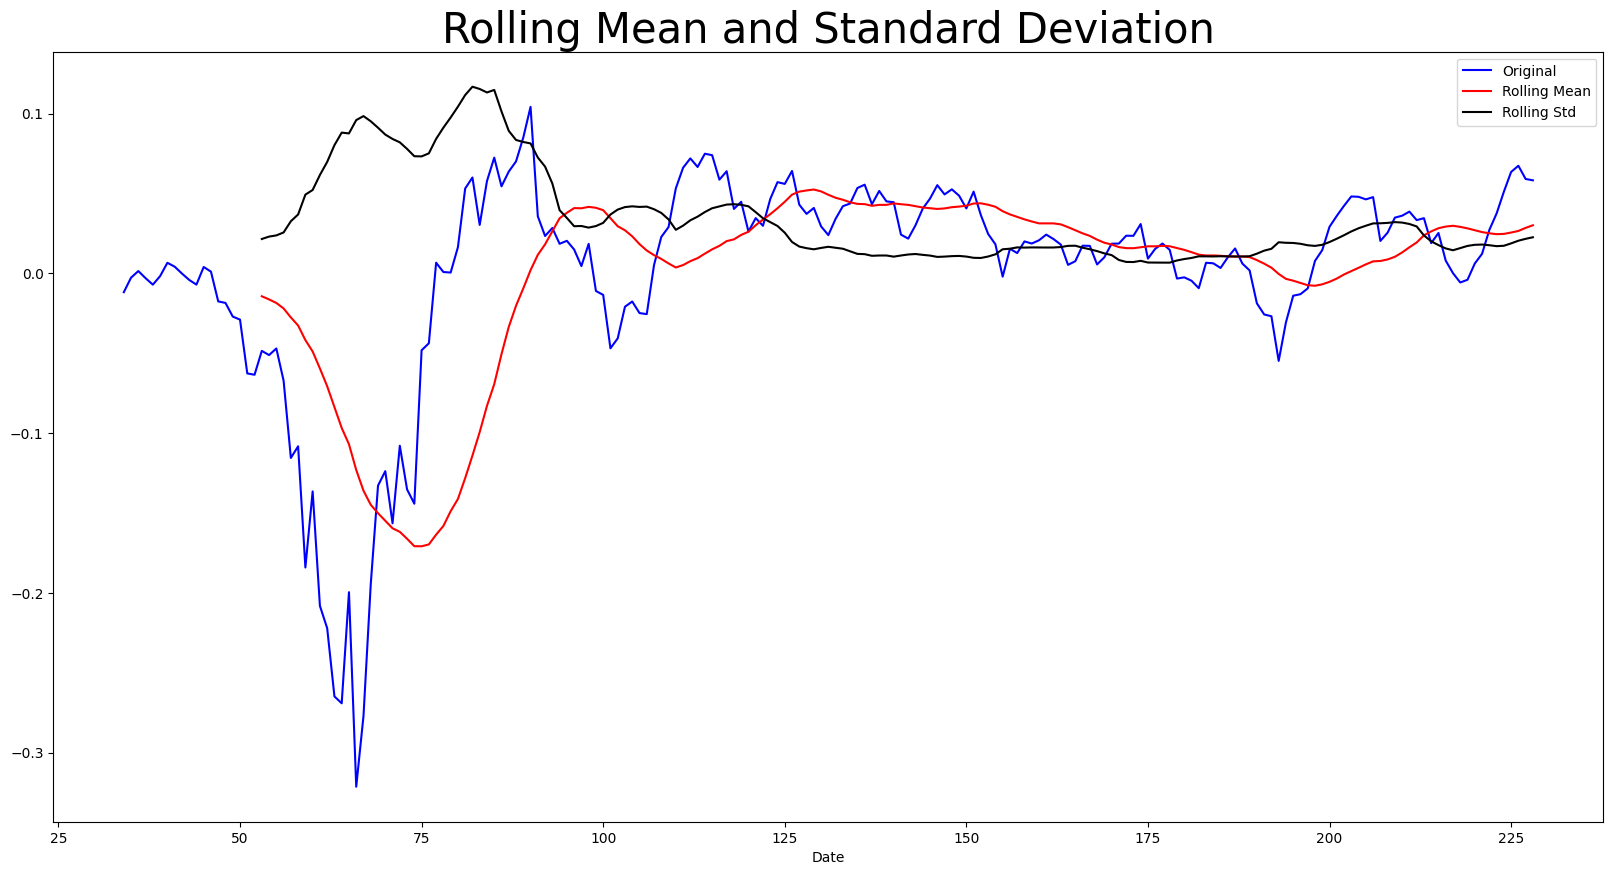

Results of Dickey-Fuller Test
ADF Test Statistic : -2.839838982126019
p-value : 0.05280452791340235
# Lags Used : 7
Number of Observations Used : 187
Weak evidence against the null hypothesis, time series is non-stationary.


In [27]:
train_log_diff = train_log - mav
train_log_diff.dropna(inplace = True)

test_stationarity(train_log_diff)

In [33]:
#Using auto arima to make predictions using log data
#!pip install pmdarima
from pmdarima import auto_arima


In [34]:
model = auto_arima(train_log, trace = True, error_action = 'ignore', suppress_warnings = True)
model.fit(train_log)
predictions = model.predict(periods = len(test))
predictions = pd.DataFrame(predictions,index = test_log.index,columns=['Prediction'])

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-1229.181, Time=0.57 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1228.630, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1231.551, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1230.976, Time=0.39 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1230.477, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-1230.063, Time=0.49 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1229.768, Time=0.52 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-1232.322, Time=0.98 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-1228.479, Time=0.26 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-1233.522, Time=1.03 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-1230.635, Time=0.69 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-1233.461, Time=0.89 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-1231.040, Time=0.37 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-1233.264, Time=0.58 sec
 ARIMA(1,1,2)(0,0,0

Text(0, 0.5, 'Actual Stock Price')

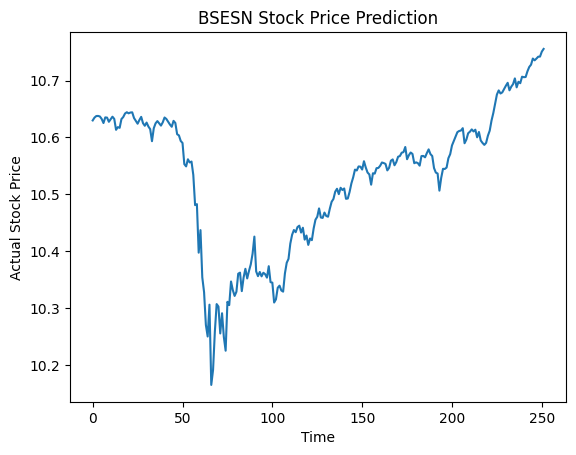

In [35]:
plt.plot(train_log, label='Train')
plt.plot(test_log, label='Test')
plt.plot(predictions, label='Prediction')
plt.title('BSESN Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')

# Textual Analysis

In [36]:
#Functions to get the subjectivity and polarity
def getSubjectivity(text):
  return TextBlob(text).sentiment.subjectivity

def getPolarity(text):
  return  TextBlob(text).sentiment.polarity

In [37]:
#Adding subjectivity and polarity columns
ndf['Subjectivity'] = ndf['News'].apply(getSubjectivity)
ndf['Polarity'] = ndf['News'].apply(getPolarity)
ndf

,Date,News,Subjectivity,Polarity
0,2001-01-02,Status quo will not be disturbed at Ayodhya s...,0.286859,0.143590
1,2001-01-03,Powerless north India gropes in the dark Think...,0.392857,0.089286
2,2001-01-04,The string that pulled Stephen Hawking to Indi...,0.445360,0.093039
3,2001-01-05,Light combat craft takes India into club class...,0.480553,0.264024
4,2001-01-06,Light combat craft takes India into club class...,0.439394,0.248485
...,...,...,...,...
7712,2022-03-27,Playing a dead man in Body God meant sitting i...,0.365123,0.034162
7713,2022-03-28,As fashion becomes democratic demand for styl...,0.383007,0.058513
7714,2022-03-29,Bobby Deol Like my dad I hope to be working ...,0.403627,0.092144
7715,2022-03-30,I will not give in to trends Dossmode The tim...,0.344136,0.039954


In [38]:
#Adding sentiment score to df_news
# Download the VADER lexicon
nltk.download('vader_lexicon')

# Create a SentimentIntensityAnalyzer object
sia = SentimentIntensityAnalyzer()


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [39]:
ndf['Compound'] = [sia.polarity_scores(v)['compound'] for v in ndf['News']]
ndf['Negative'] = [sia.polarity_scores(v)['neg'] for v in ndf['News']]
ndf['Neutral'] = [sia.polarity_scores(v)['neu'] for v in ndf['News']]
ndf['Positive'] = [sia.polarity_scores(v)['pos'] for v in ndf['News']]
ndf

,Date,News,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,2001-01-02,Status quo will not be disturbed at Ayodhya s...,0.286859,0.143590,-0.9792,0.121,0.809,0.071
1,2001-01-03,Powerless north India gropes in the dark Think...,0.392857,0.089286,-0.8910,0.156,0.735,0.109
2,2001-01-04,The string that pulled Stephen Hawking to Indi...,0.445360,0.093039,0.7543,0.104,0.792,0.104
3,2001-01-05,Light combat craft takes India into club class...,0.480553,0.264024,0.9645,0.142,0.694,0.164
4,2001-01-06,Light combat craft takes India into club class...,0.439394,0.248485,-0.8316,0.214,0.655,0.131
...,...,...,...,...,...,...,...,...
7712,2022-03-27,Playing a dead man in Body God meant sitting i...,0.365123,0.034162,-0.9999,0.158,0.758,0.084
7713,2022-03-28,As fashion becomes democratic demand for styl...,0.383007,0.058513,-0.9999,0.160,0.737,0.103
7714,2022-03-29,Bobby Deol Like my dad I hope to be working ...,0.403627,0.092144,-0.9999,0.159,0.755,0.086
7715,2022-03-30,I will not give in to trends Dossmode The tim...,0.344136,0.039954,-0.9999,0.156,0.769,0.076


# Merge the Historical and Textual Data

In [96]:
df_merge = pd.merge(hisdf, ndf, how='inner', on='Date')
df_merge

,Date,Open,High,Low,Close,Volume,News,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,2019-12-17,41052.359375,41401.648438,41005.179688,41352.171875,19000.0,After Jagannath Temple Puri beach devpt plan ...,0.356256,0.037977,-1.0000,0.206,0.715,0.079
1,2019-12-18,41442.750000,41614.769531,41358.468750,41558.570313,24300.0,What is Citizenship Amendment Bill All...,0.396291,0.039680,-0.9999,0.164,0.754,0.082
2,2019-12-19,41571.820313,41719.289063,41456.398438,41673.921875,33300.0,Only of CCA covered after revamp of canals...,0.371783,0.029115,-0.9998,0.135,0.797,0.068
3,2019-12-20,41746.199219,41809.960938,41636.109375,41681.539063,33600.0,I'm done playing the good girl I want to be a...,0.366210,0.047456,-0.9999,0.179,0.733,0.088
4,2019-12-23,41548.261719,41701.621094,41474.609375,41642.660156,6200.0,Weekly Horoscope December Check predic...,0.393635,0.036077,-0.9999,0.157,0.753,0.091
...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,2020-12-11,46060.320313,46309.628906,45706.218750,46099.011719,26300.0,Ways to get you in the mood for sex when you'r...,0.374037,0.052291,-0.9999,0.168,0.743,0.089
248,2020-12-14,46284.699219,46373.339844,45951.531250,46253.460938,18400.0,No threat from Covid claims to balance sheets ...,0.382335,0.072333,-0.9996,0.128,0.776,0.095
249,2020-12-15,46287.390625,46350.300781,45841.671875,46263.171875,16400.0,RT PCR tests in a day only found ve ...,0.368751,0.039336,-0.9999,0.145,0.767,0.089
250,2020-12-16,46573.308594,46704.968750,46402.199219,46666.460938,13100.0,Asmita Sood's favourite holiday destinations a...,0.427681,0.067088,-0.9997,0.124,0.793,0.083


# Create Dataset for Model Training

In [97]:
dfmerge1 = df_merge[['Close','Subjectivity', 'Polarity', 'Compound', 'Negative', 'Neutral', 'Positive']]
dfmerge1

,Close,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,41352.171875,0.356256,0.037977,-1.0000,0.206,0.715,0.079
1,41558.570313,0.396291,0.039680,-0.9999,0.164,0.754,0.082
2,41673.921875,0.371783,0.029115,-0.9998,0.135,0.797,0.068
3,41681.539063,0.366210,0.047456,-0.9999,0.179,0.733,0.088
4,41642.660156,0.393635,0.036077,-0.9999,0.157,0.753,0.091
...,...,...,...,...,...,...,...
247,46099.011719,0.374037,0.052291,-0.9999,0.168,0.743,0.089
248,46253.460938,0.382335,0.072333,-0.9996,0.128,0.776,0.095
249,46263.171875,0.368751,0.039336,-0.9999,0.145,0.767,0.089
250,46666.460938,0.427681,0.067088,-0.9997,0.124,0.793,0.083


# Normalize Data

In [98]:
scaler = MinMaxScaler()

df = pd.DataFrame(scaler.fit_transform(dfmerge1))
df.columns = dfmerge1.columns
df.index = dfmerge1.index
df.head()

,Close,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,0.735131,0.157604,0.254831,0.00000,0.913386,0.044118,0.296296
1,0.745002,0.537627,0.270044,0.00005,0.582677,0.330882,0.333333
2,0.750519,0.304990,0.175669,0.00010,0.354331,0.647059,0.160494
3,0.750884,0.252084,0.339500,0.00005,0.700787,0.176471,0.407407
4,0.749024,0.512408,0.237860,0.00005,0.527559,0.323529,0.444444


In [99]:
X=df.drop('Close',axis=1)


In [100]:

Y=df['Close']
Y.fillna(0,inplace=True)



# Split the Dataset into Train & Test Data

In [101]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state = 0)
x_train.shape

(201, 6)

In [102]:
x_train[:10]

,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
162,0.465301,0.454071,0.000100,0.338583,0.610294,0.246914
159,0.439622,0.293848,0.000050,0.551181,0.375000,0.308642
76,0.502568,0.748241,0.000151,0.322835,0.588235,0.308642
59,0.688751,0.079482,0.000000,0.905512,0.007353,0.382716
176,0.571862,0.434155,0.000050,0.519685,0.308824,0.469136
229,0.906249,0.782032,0.000251,0.393701,0.272059,0.728395
18,0.333780,0.772958,0.000050,0.606299,0.235294,0.456790
221,0.549120,0.343538,0.000201,0.244094,0.647059,0.333333
15,0.542581,0.318921,0.000050,0.433071,0.529412,0.234568
152,0.579137,0.276312,0.000050,0.417323,0.470588,0.345679


# RandomForestRegressor Model

In [103]:
rf = RandomForestRegressor()

rf.fit(x_train, y_train)
prediction=rf.predict(x_test)

In [104]:
print(prediction[:10])
print(y_test[:10])
print('Mean Squared error: ',mean_squared_error(prediction,y_test))

[0.69419349 0.44118031 0.37952701 0.62156352 0.66488611 0.49655957
 0.47722413 0.39745844 0.4047625  0.55742411]
158    0.576027
83     0.222653
170    0.613027
101    0.193587
150    0.571688
199    0.621378
118    0.361428
227    0.831023
63     0.138135
135    0.502463
Name: Close, dtype: float64
Mean Squared error:  0.046685716540742064


# DecisionTreeRegressor Model

In [105]:
dtr = DecisionTreeRegressor()
dtr.fit(x_train, y_train)
predictions = dtr.predict(x_test)

In [106]:
print(predictions[:10])
print(y_test[:10])
print('Mean Squared error: ',mean_squared_error(predictions,y_test))

[0.84233334 0.96954059 0.2243688  0.42949144 0.65747307 0.76099969
 0.27076532 0.29333063 0.18818222 0.64498561]
158    0.576027
83     0.222653
170    0.613027
101    0.193587
150    0.571688
199    0.621378
118    0.361428
227    0.831023
63     0.138135
135    0.502463
Name: Close, dtype: float64
Mean Squared error:  0.10553263654656606


# AdaBoostRegressor Model

In [107]:
adb = AdaBoostRegressor()
adb.fit(x_train, y_train)

AdaBoostRegressor()

In [108]:
predictions = adb.predict(x_test)
print(mean_squared_error(predictions, y_test))

0.048000919510098605


# LGBMRegressor Model

In [109]:
gbm = lightgbm.LGBMRegressor()
gbm.fit(x_train, y_train)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000056 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 285
[LightGBM] [Info] Number of data points in the train set: 201, number of used features: 6
[LightGBM] [Info] Start training from score 0.558192
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

LGBMRegressor()

In [110]:
predictions = gbm.predict(x_test)
print(mean_squared_error(predictions, y_test))

0.04555770017211517


# XGBRegressor Model

In [111]:
xgb = xgboost.XGBRegressor()
xgb.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [112]:
predictions = xgb.predict(x_test)
print(mean_squared_error(predictions, y_test))

0.05909834737190337
